In [1]:
from utils import *
np.random.seed(42)

In [2]:
data = loadmat("subjects/s2/S2_A1_E1.mat")
emg = data["emg"]
emg_rectified = data["emg"].copy()
stimulus = data['restimulus']
repetition = data['rerepetition']

In [3]:
# Step 1: Pre-process EMG data to calculate envelopes
# `emg_envelope` computes the moving average (envelope) for rectified EMG signals 
# based on the given stimulus and repetition indices.
emg_envelopes = emg_envelope(emg_rectified, stimulus, repetition)

# Step 2: Calculate average activations
# `emg_average_activations` computes the mean activation levels for each channel,
# stimulus, and repetition to facilitate identifying anomalous trials.

emg_average_activations = compute_emg_average_activations(emg_envelopes)
# Step 3: Identify trials to exclude
# `trial_to_exclude_all` identifies trials (repetitions) that deviate significantly 
# from the average activation using a threshold (based on standard deviation or IQR).
# - `threshold_factor`: Adjusts the sensitivity of outlier detection.
# - `use_iqr`: If True, uses interquartile range instead of standard deviation.

exclude_list = trial_to_exclude_all(emg_envelopes, window_ms=2000, warnings = True) # 2000ms = 2s
# exclude_list = []
feature_functions = [mav, rms, wl, ssc,std, mf, maxav]

# Step 5: Build the dataset
# `build_dataset_from_ninapro` extracts features using the defined feature functions
# for the processed EMG envelopes. It also excludes the identified anomalous trials.
# - `emg_envelopes`: The processed EMG envelope data.
# - `features`: List of feature extraction functions.
# - `exclude_list`: Trials marked for exclusion to ensure clean data.
dataset, labels = build_dataset_from_ninapro(emg_envelopes, features=feature_functions, exclude_list=exclude_list)

Trials to exclude for Stimulus 1: []
Trials to exclude for Stimulus 2: []
Trials to exclude for Stimulus 3: []
Channel 6 is saturated.
Trials to exclude for Stimulus 4: [10]
Channel 6 is saturated.
Trials to exclude for Stimulus 5: [1]
Trials to exclude for Stimulus 6: []
Trials to exclude for Stimulus 7: []
Channel 6 is saturated.
Channel 6 is saturated.
Trials to exclude for Stimulus 8: [1, 4]
Trials to exclude for Stimulus 9: []
Trials to exclude for Stimulus 10: []
Trials to exclude for Stimulus 11: []
Trials to exclude for Stimulus 12: []


### Question 1 
 Does the data look reasonable? Did you need to remove any trials?

In general the data looks reasonable as can be checked by the homogeinity observed within rows of the heatmap displayed below. Each row represents the mean value for a specific channel over diferent repetitions of the same movement (stimuli) thus should not change much. However we see that some columns stand out from the remaining ones. We implemented two different methods to exclude trials based on the distance to the other ones: interquartile distance and mean distribution + euclidian distance. This methods will be tested later for better accuracy results.

Notes: he said that when removing trials we should inspect why it is happening? so reaalyy look to the channels and give an explanation. Also see stimulus 2 channel 3 i thinnk because maybe shomething was unploged give thhe low values of the signal? could it no be just because the muscle is not being activated? no because the values would be bigger.

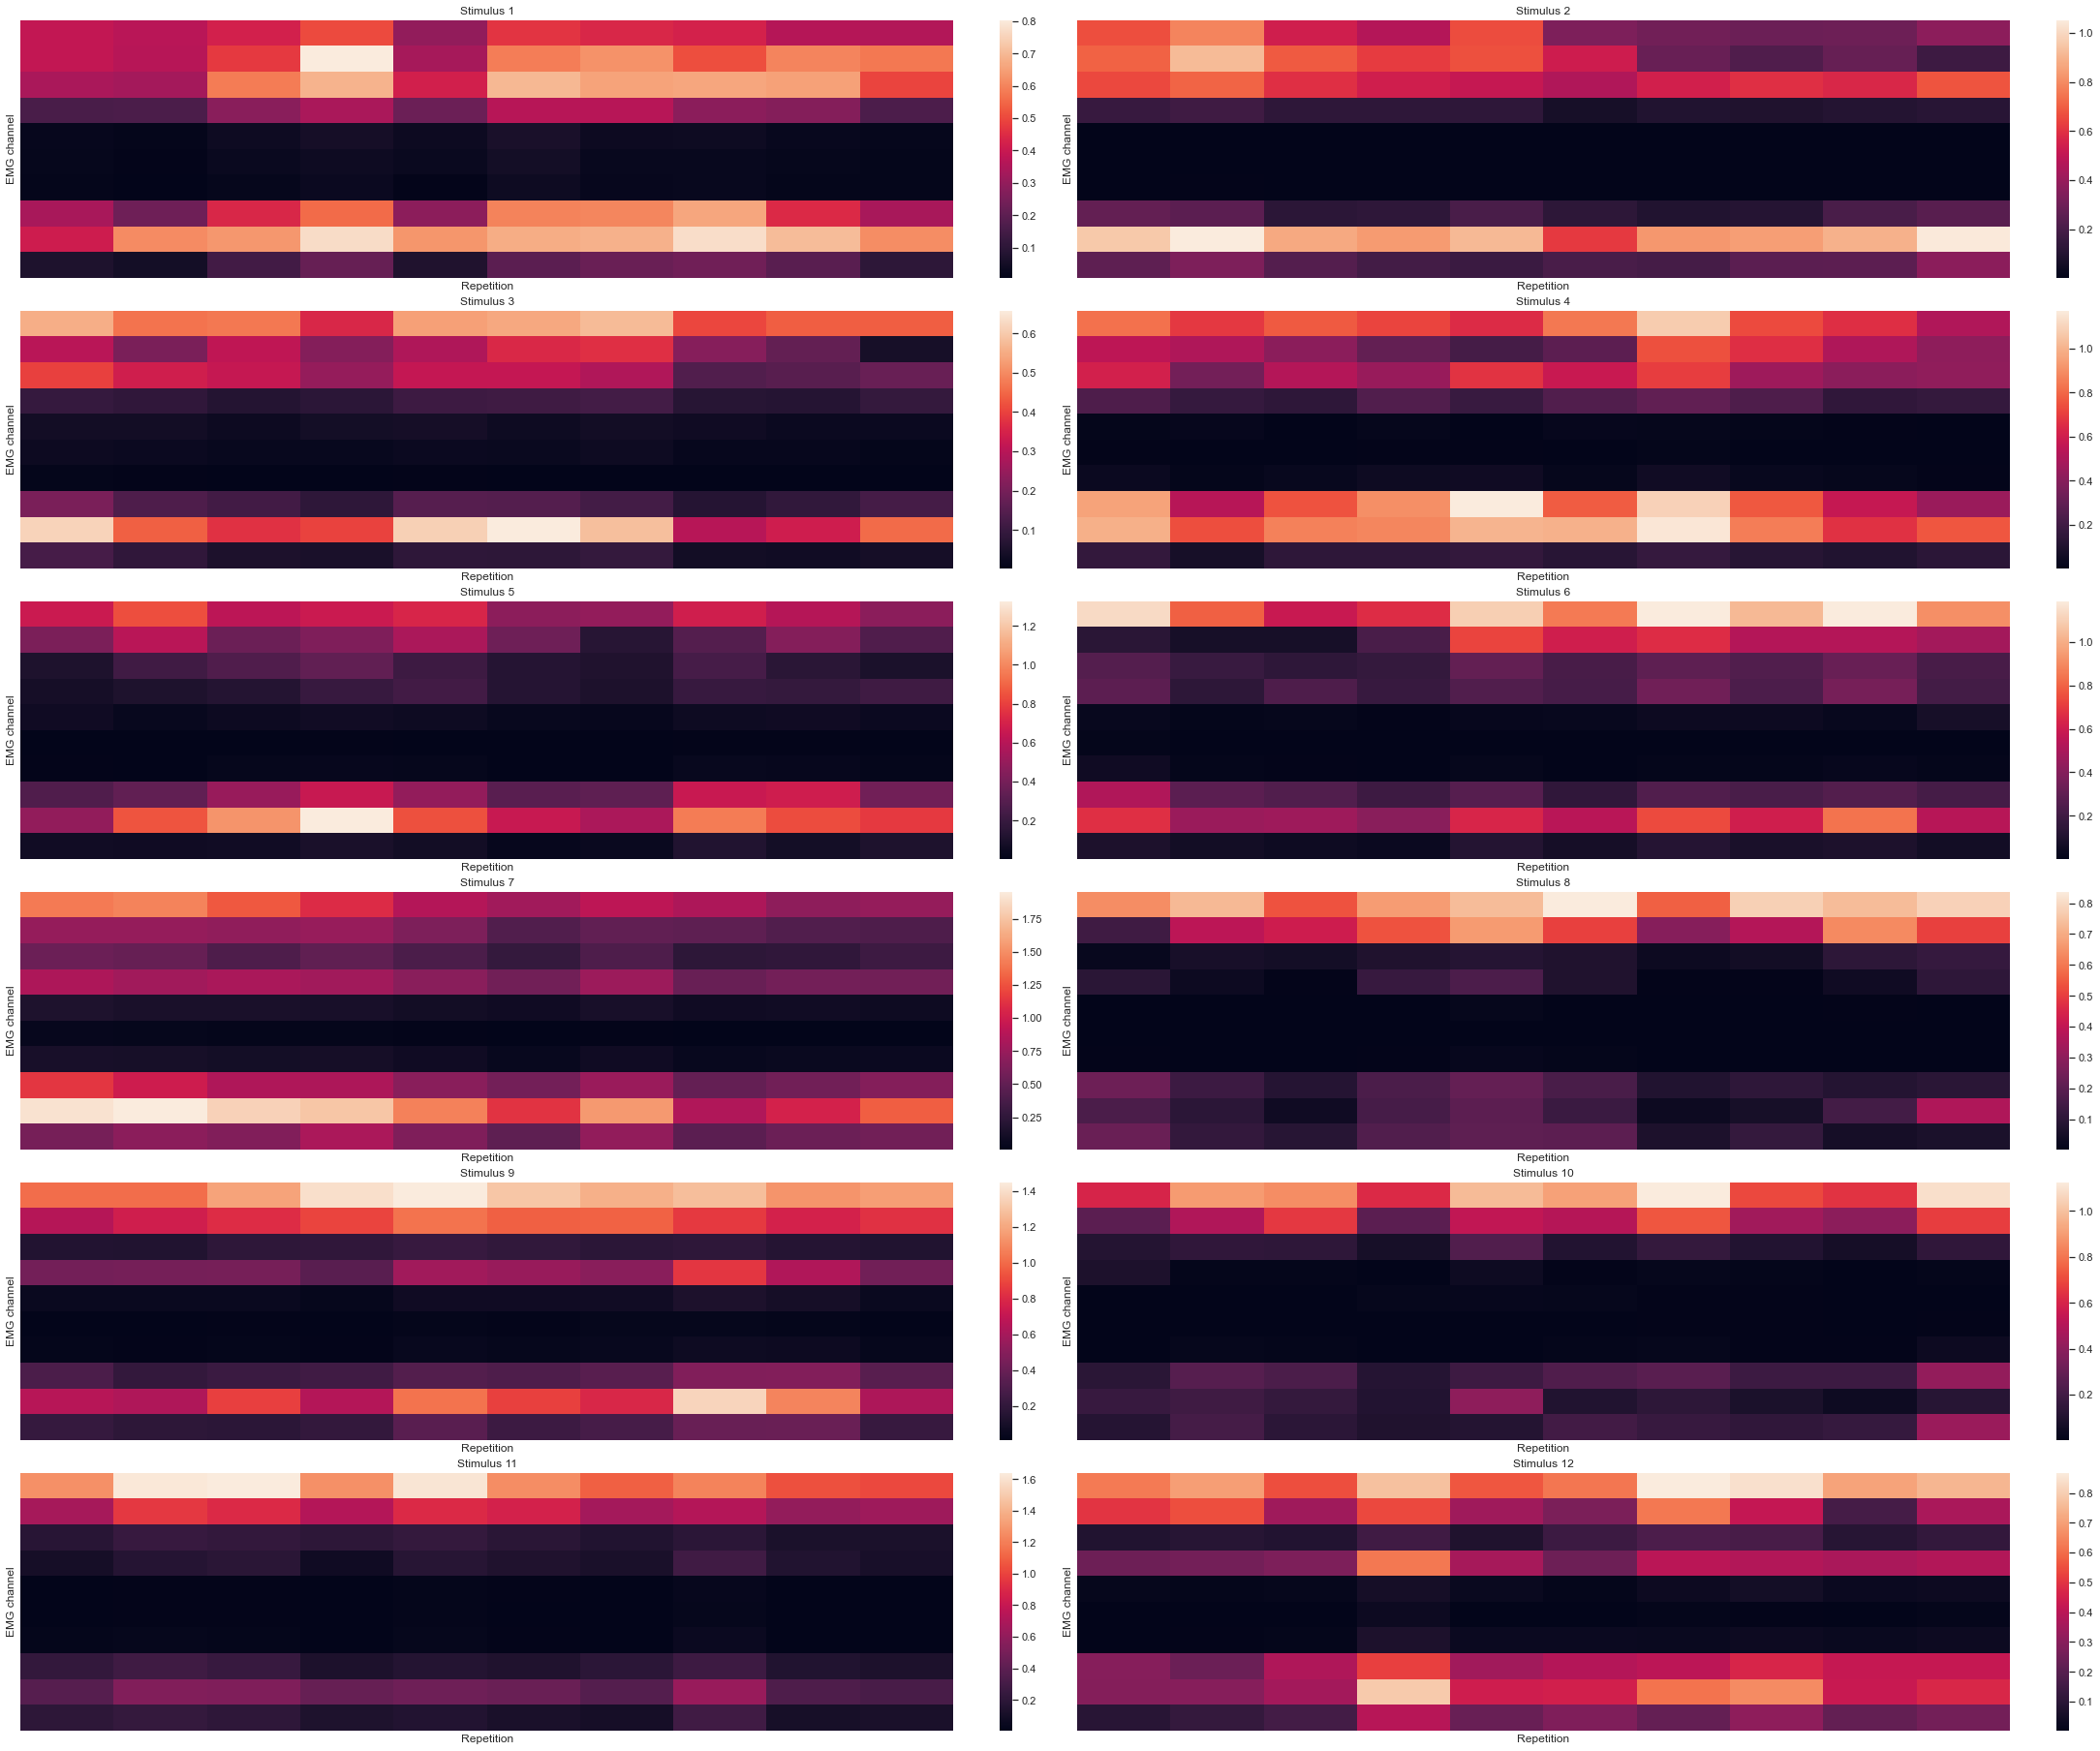

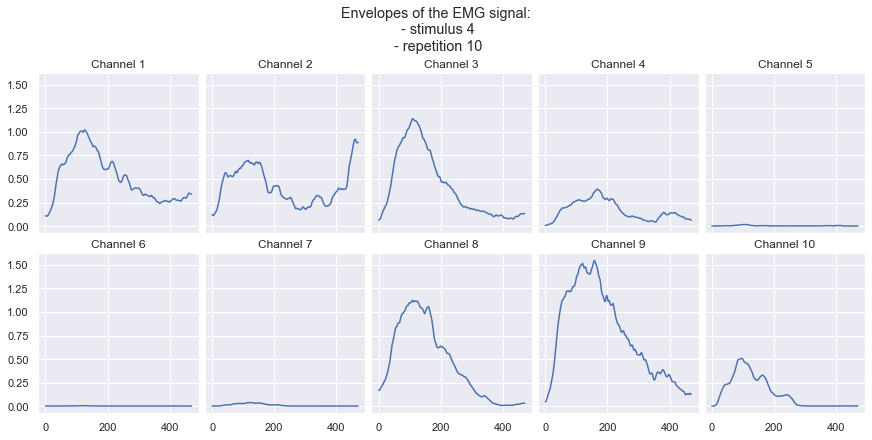

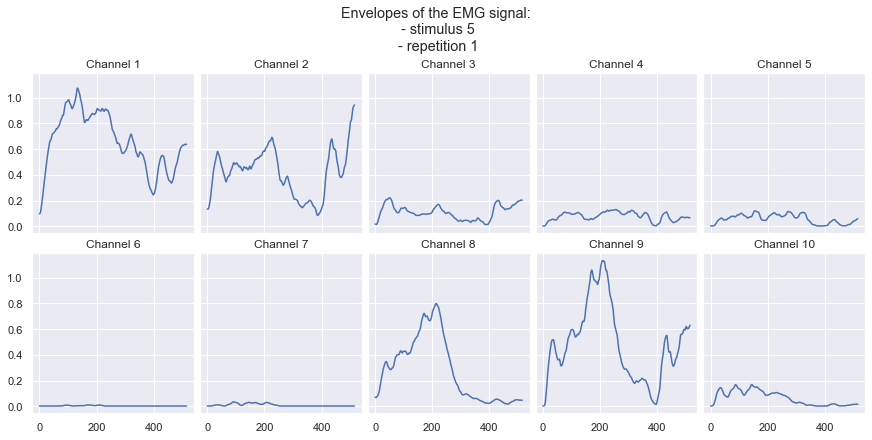

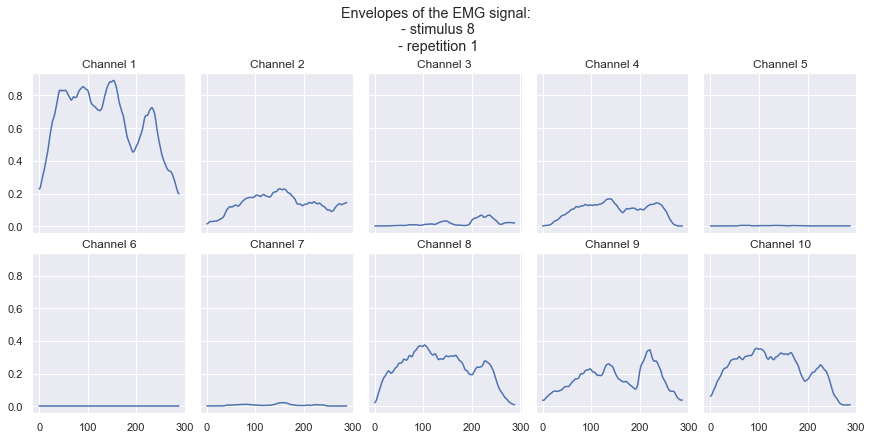

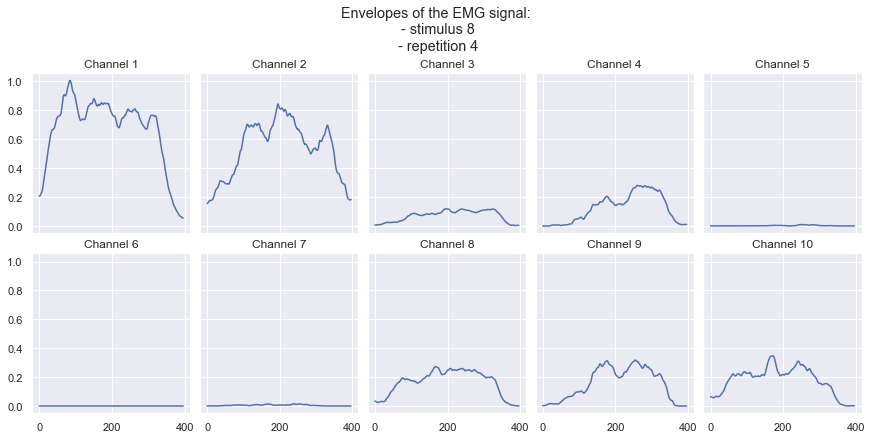

In [4]:
plot_heatmap(emg_average_activations)
#plot to see trials to remove and why 
for stimuli_index in range(len(exclude_list)):
    if len(exclude_list[stimuli_index]) != 0:
        for repetition_index in exclude_list[stimuli_index]:
            plot_envelopes(emg_envelopes, stimuli_index = stimuli_index, repetition_index= repetition_index)

### Question 2

Why do we need the different datasets?

We would answer this by answering why one could not use the same dataset. If only one dataset is used for training, validation, and testing, the model risks overfitting by memorizing the training data rather than learning generalizable patterns, leading to poor performance on new data. Evaluation on the same dataset would produce overly optimistic results that fail to reflect real-world performance. Additionally, without a separate validation set, there is no way to monitor or refine the model during training, leaving hyperparameters untuned and performance unchecked.

### Question 3
Are the values similar between repetitions and between channels?

Below we plot the seven calculated features for all ten repetitions, grouped per stimulus, for all ten channels.

The values show consistency in trends across repetitions of the same stimulus, as indicated by the similar shapes of the lines within each subplot. This is expected because repetitions of the same movement should activate similar muscle groups consistently, leading to reproducible patterns.

However, there is clear variability between channels, as evidenced by the distinct vertical offsets and differences in the overall shape of the curves across channels. This variation is biologically plausible since each channel corresponds to a specific electrode location, capturing activity from different muscles or muscle groups. Differences in electrode positioning, muscle activation levels, or the intrinsic properties of the muscles contribute to this channel-to-channel variability.

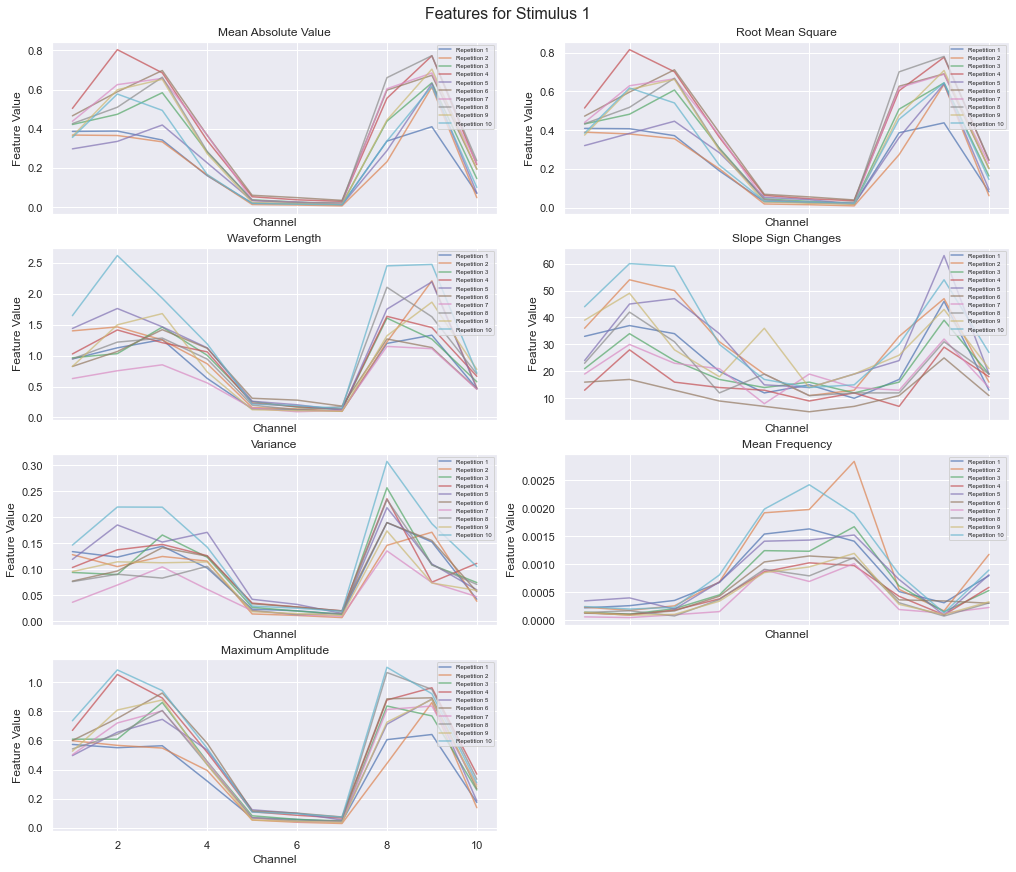

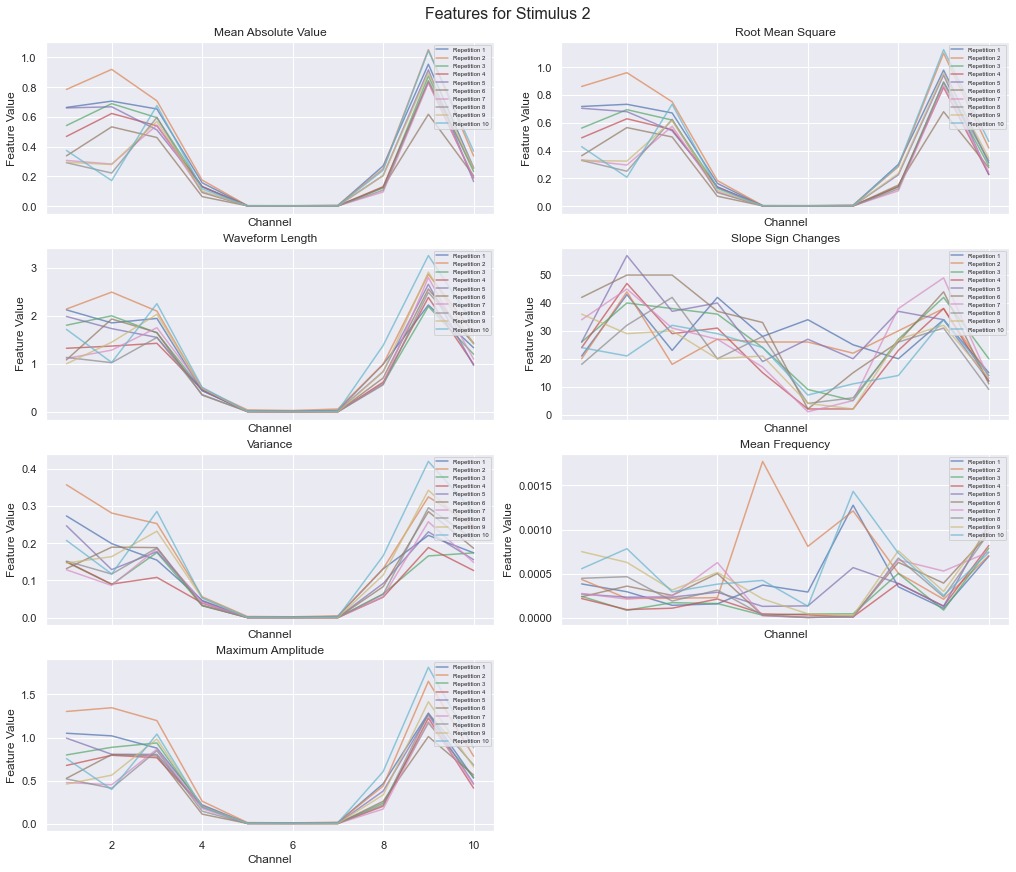

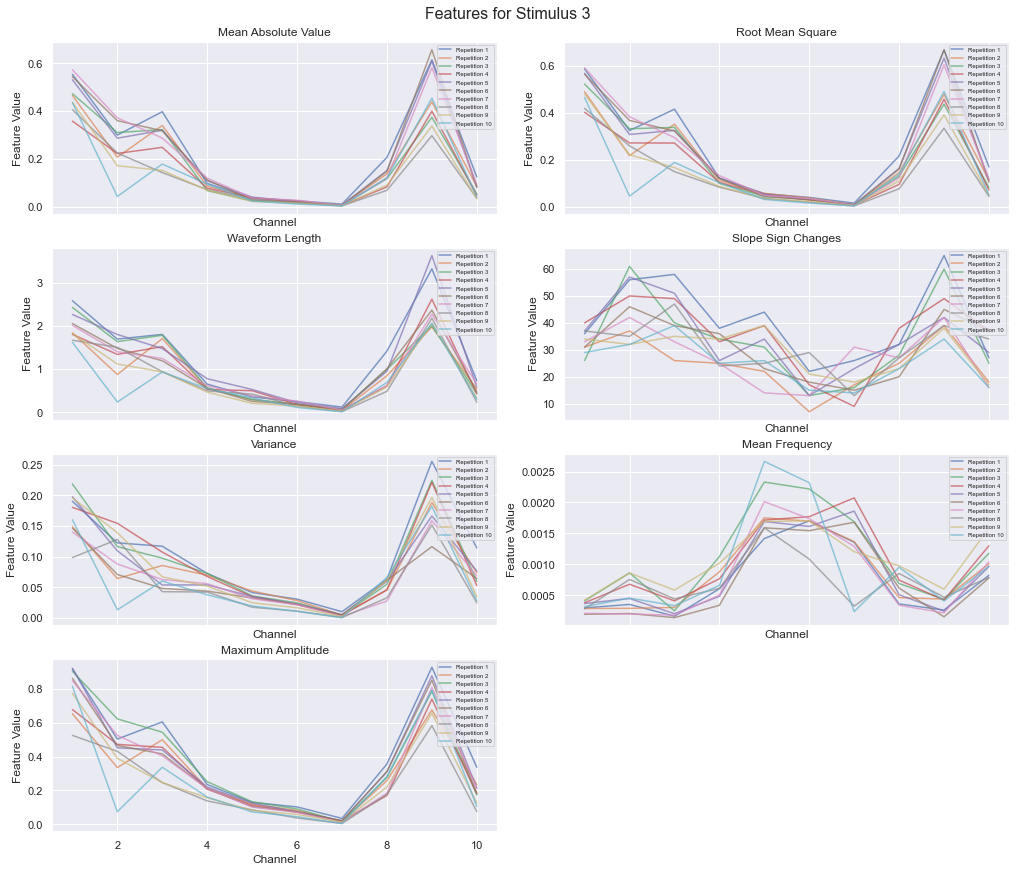

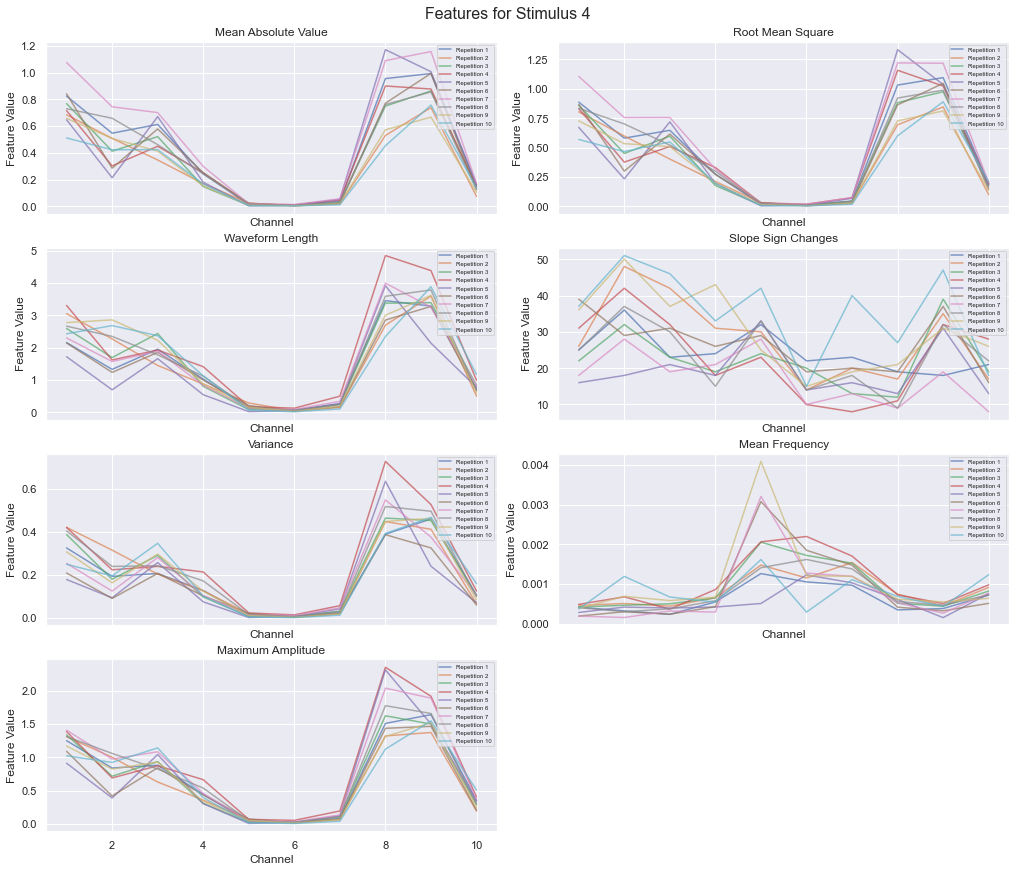

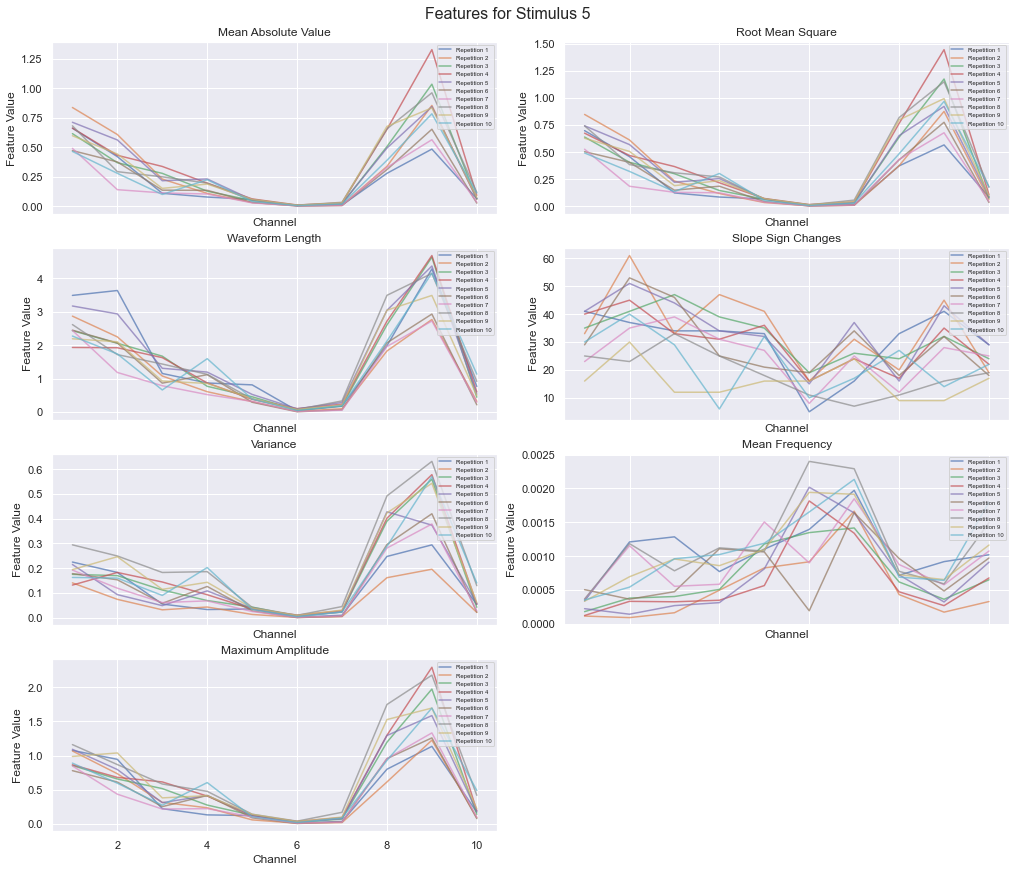

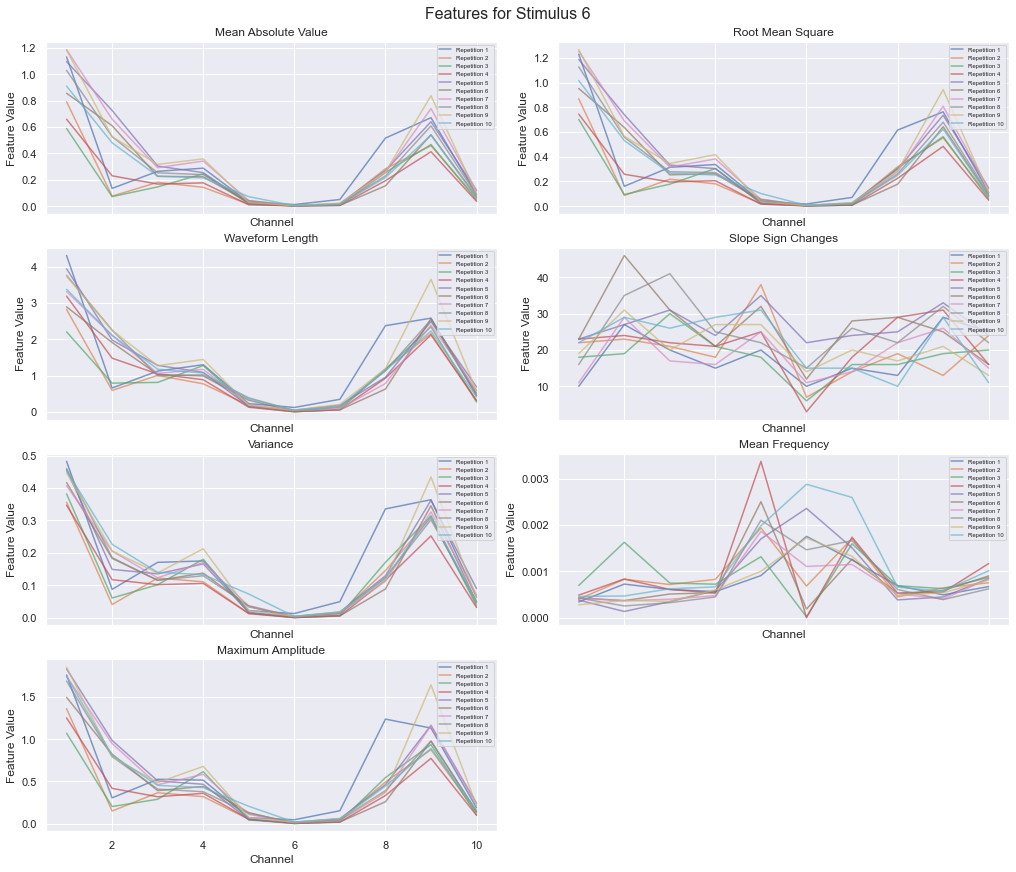

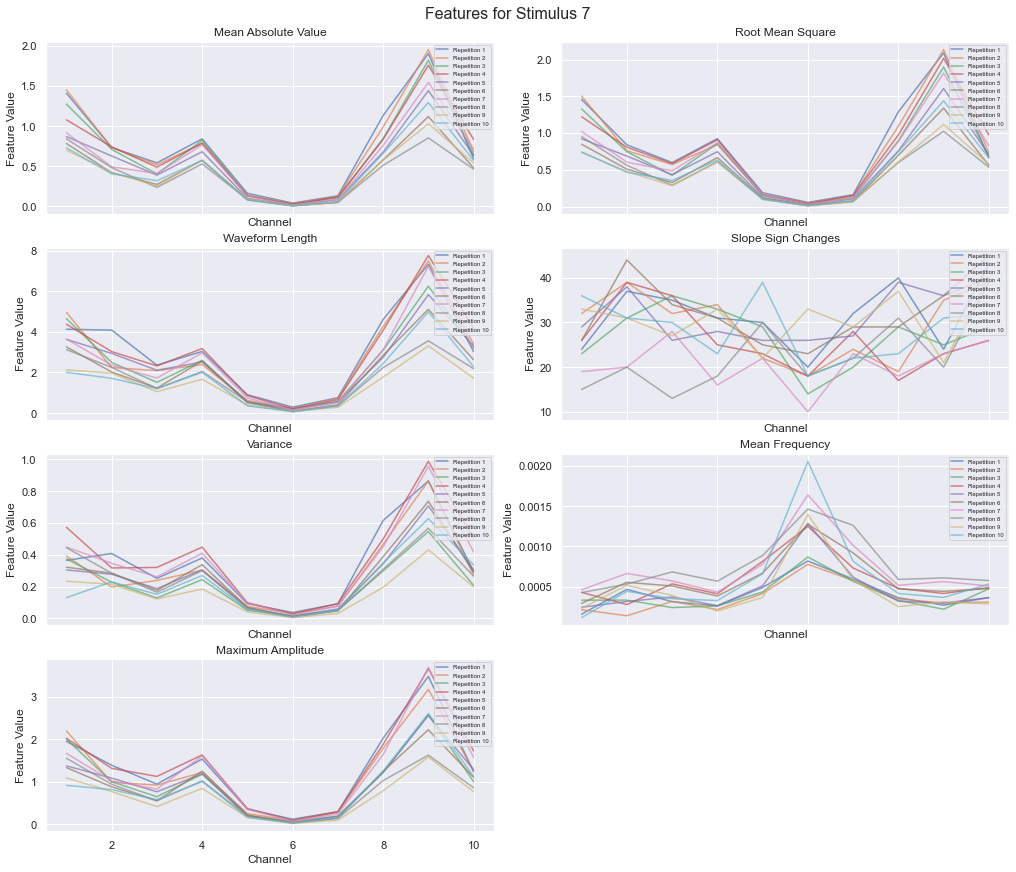

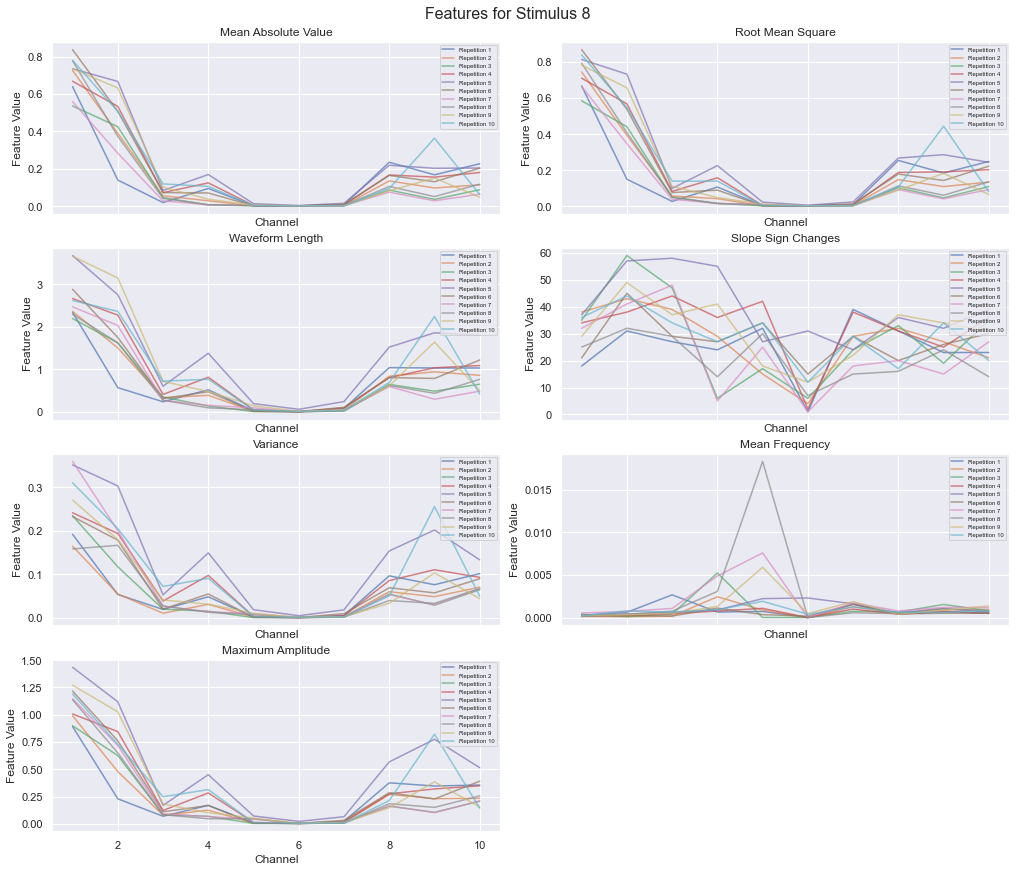

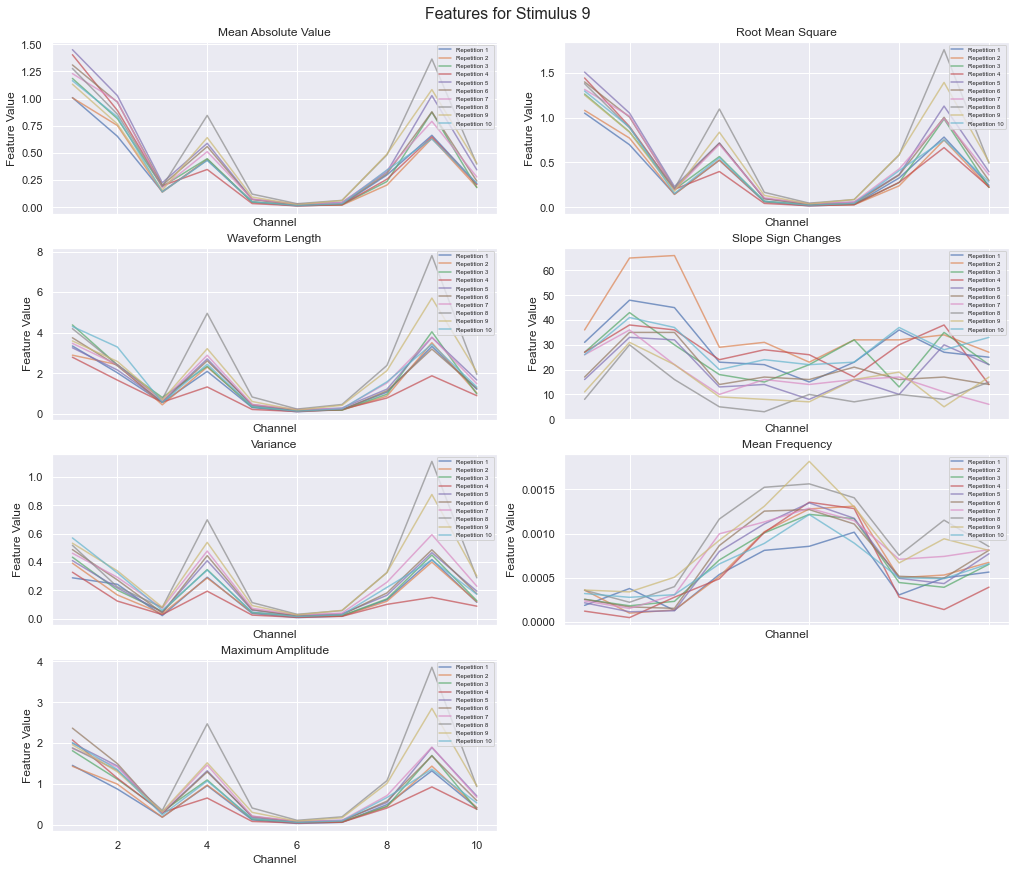

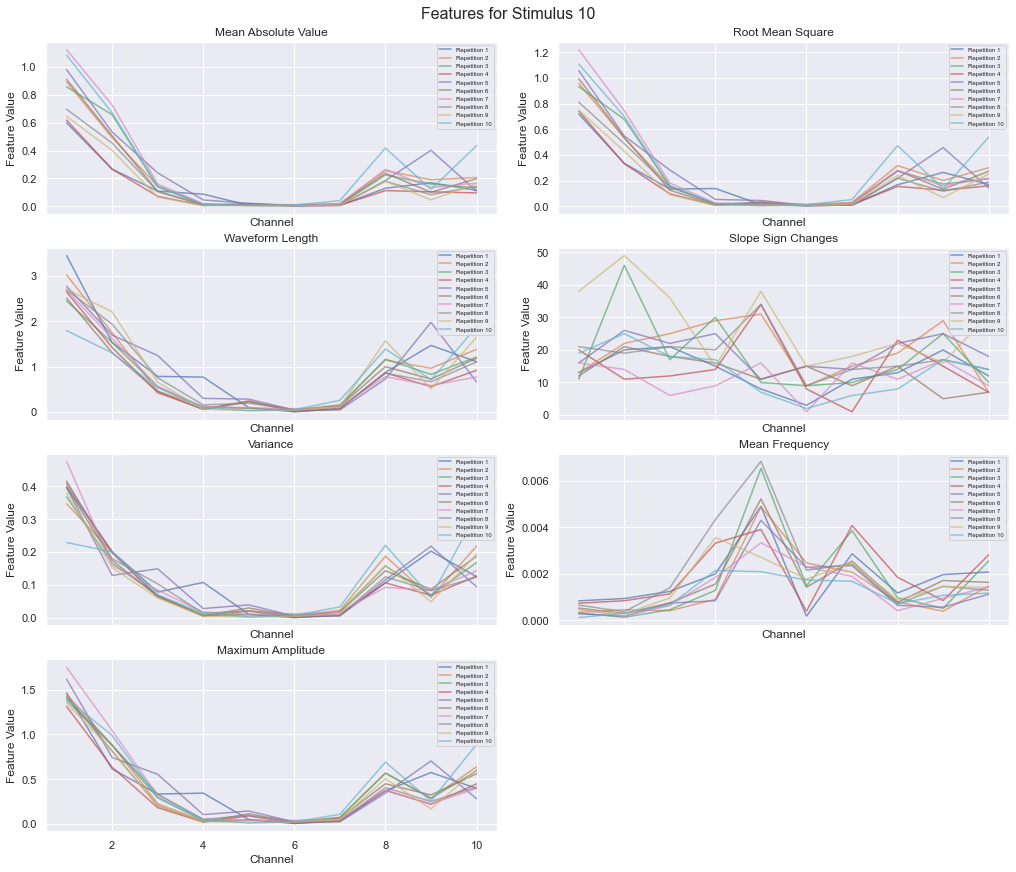

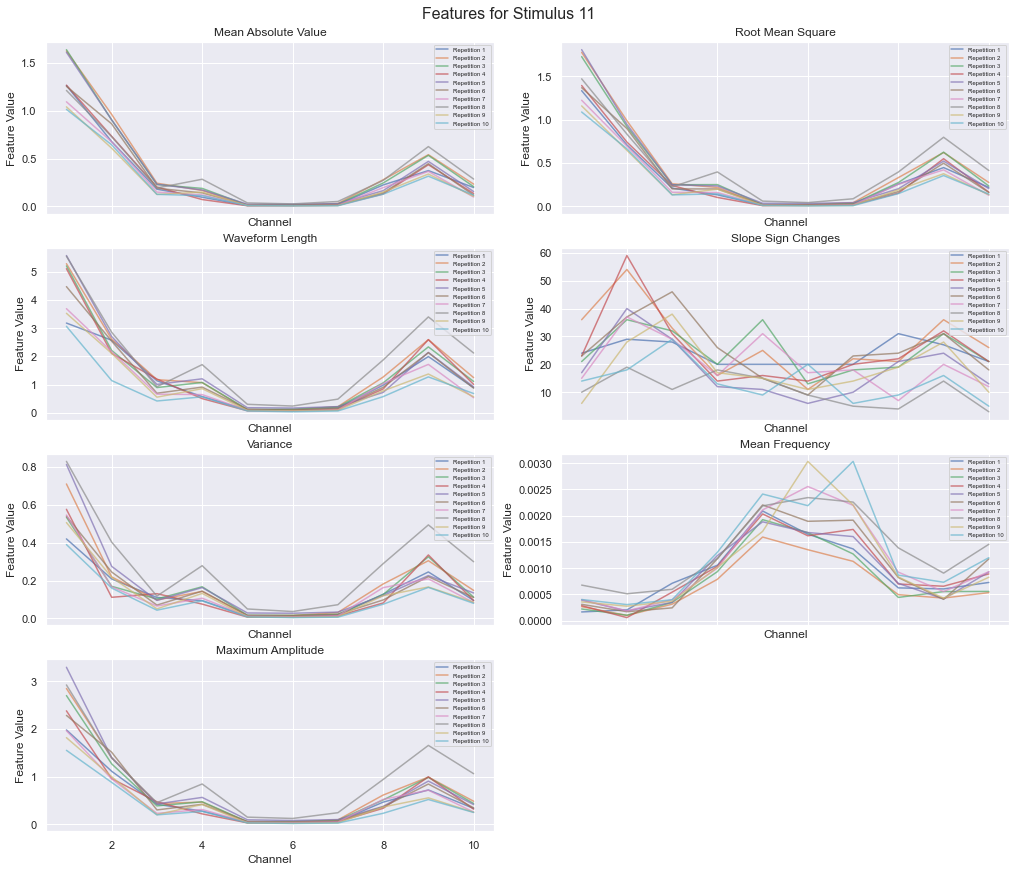

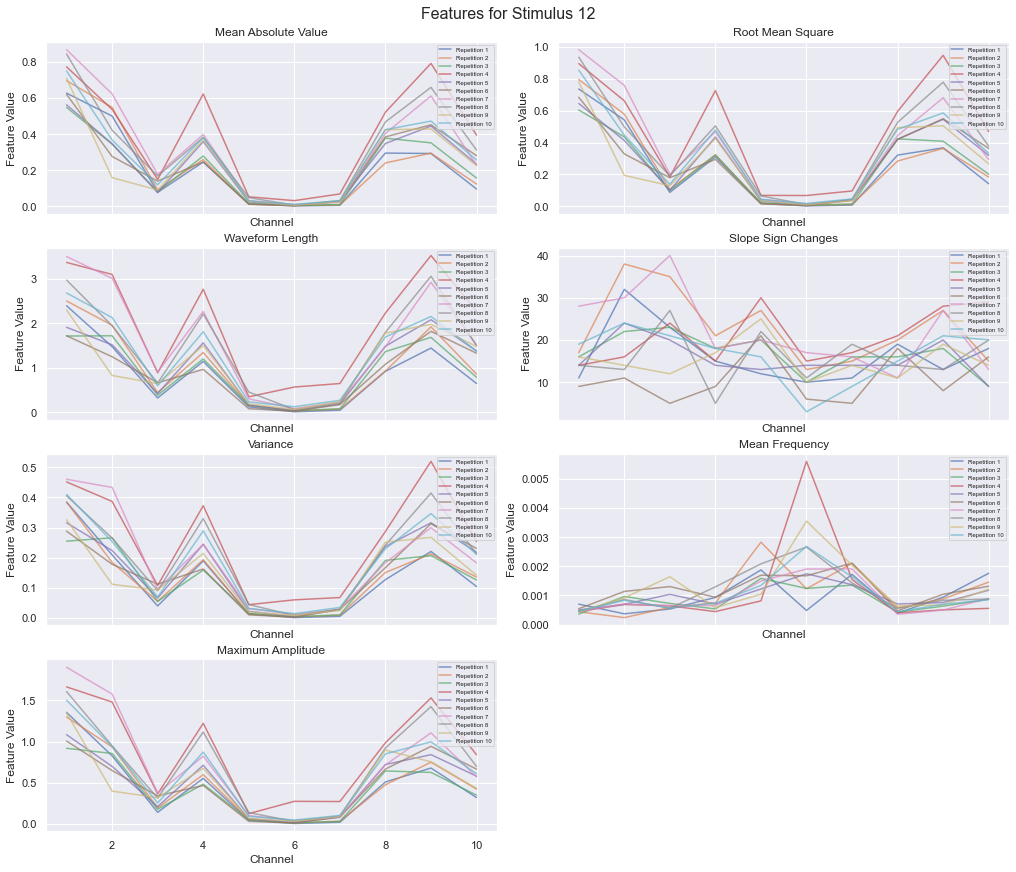

In [5]:
dataset, labels = build_dataset_from_ninapro(emg_envelopes, features=feature_functions, exclude_list=None)
plot_features_by_stimulus_and_metric(dataset, labels, n_stimuli = 12, n_repetitions =10, n_channels=10)

### Question 4 & 5

Hyperparameter tuning.

During hyperparameter tuning for the Random Forest classifier, we try to find the right number for (1) the estimators, (2) the depth, (3) the number of samples per split, and (4) the number of minimum samples per leaf.

We use the GridSearchCV from scikit-learn to help us in this. We define a grid over which GridSearch will compute the Random Forest classification for each combination of parameters. First, we split the data into train and test set. We pass the train set to GridSearchCV, which internally performs 7-fold cross-validation. The train set is thus (implicity) divided into a train and validation set during cross-validation. For each of the parameter combinations, GridSearch calculates the average accuracy over all 7 folds, and selects the best model. We save the best model and best parameter combination (<best_model>, <best_params>).

The best features are:
    - n_estimators      :
    -  max_depth        :
    - min_samples_split : 
    - min_samples_leaf  : 

For testing, we perform classification on the train set using this best model with the best parameter combination. To evaluate the performance, we calculate its accuracy and F1-score, and plot the confusion matrix. The accuracy is a good metric here thanks to it straightforwardness. We try to predict one out of 10 classes, meaning that the model is correct in 94% of the predictions. We can use accuracy because we train on balanced data. F1 is a good metric because it balances the trade-off between precision and recall. The confusion matrix shows insights into how often each class is correctly classified (diagonal entries) and misclassified as other classes (off-diagonal entries), allowing us to see which classes are more tricky to predict. Together, they give us a good understanding of how well the Random Forest model is performing. Based on an accuracy on unseen data of 94% and an F1 score of ..., we conclude that the model is performing very well.

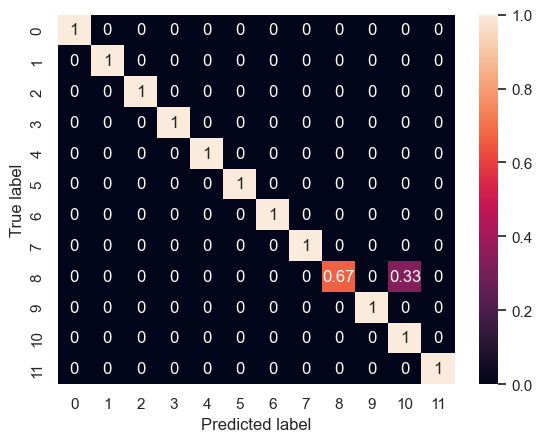

Accuracy: 97.22%, F1-score: 0.97
          - n_estimators      : 80
          - max_depth         : None
          - min_samples_split : 6
          - min_samples_leaf  : 1
          - max_features  : log2
          - bootstrap  : True
        


In [7]:
# Perform Hyperparameter tuning
param_grid = {
    'n_estimators': np.arange(0, 121, 10)[1:],
    'max_depth': [None] + list(np.arange(0, 12, 1)[1:]),
    'min_samples_split': np.arange(2, 7, 1),
    'min_samples_leaf': np.arange(1, 3, 1),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [False, True]
}

# Prepare the training and test set
# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42, stratify=labels)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test) 

(best_model, best_params, best_score, accuracy, F1_score, results) = grid_search_RF(X_train_z, X_test_z, y_train, y_test, param_grid, cv=6)

### Question 6

Feature selection/dimension reduction

We perform feature selection using (1) the feature importances after fitting the model, and (2) mutual information.

(1) After fitting the model, we can calculate the importance of each feature, i.e. how much the feature contributes to the prediction of the stimulus class. The strengths are that this is quite interpretable, and that it is relevant for this task. However, it is model-specific, may not generalize well, and does not take into account the combined effects of parameters.

For this, we choose the features that contribute the most to a total of 80% of the cumulative feature importance, resulting in 41 features. Again, we perform hyperparameter optimization.

(2) We do something similar with the mutual information, which is a measure of the dependency between variables. We calculate the mutual information between each feature and the target variable, and select the 41 features with the highest mutual information scores. This ensures that we have the same amount of features as method (1) for comparison.

Now, we can compare between the three Random Forest models, (0) without feature selection, (1) based on feature importance, and (2) based on mutual information.

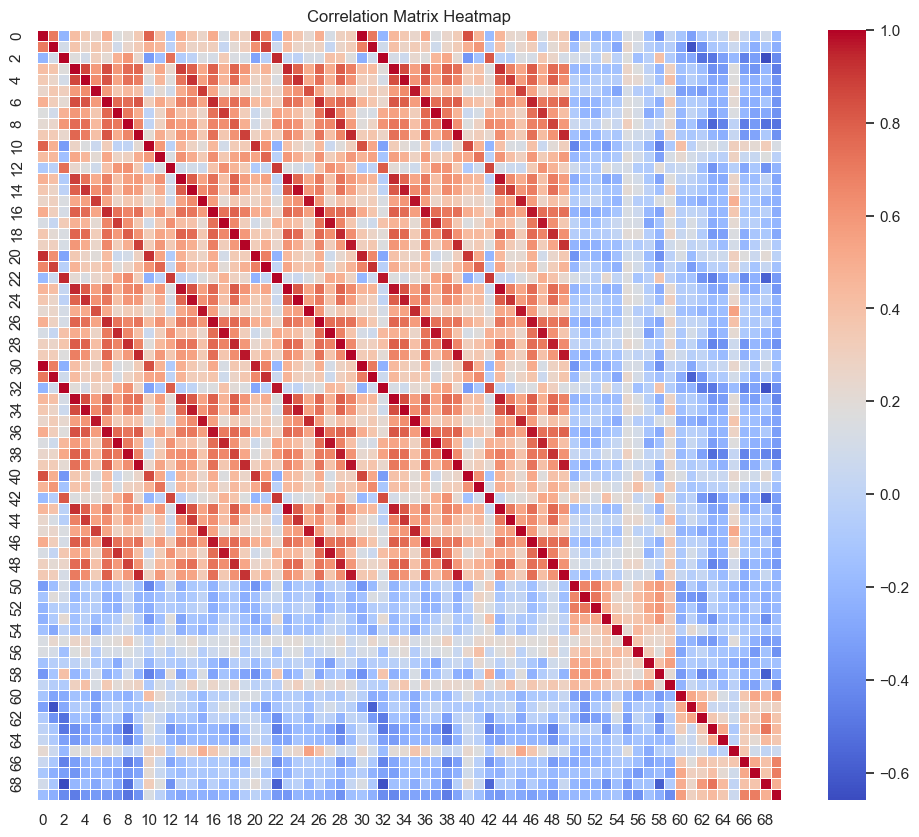

In [13]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
dataset = pd.DataFrame(dataset)
correlation_matrix = dataset.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add a title
plt.title('Correlation Matrix Heatmap')
plt.show()

/Users/charl/Documents/EPFL/NX-421 NSSP/NSSP_env/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


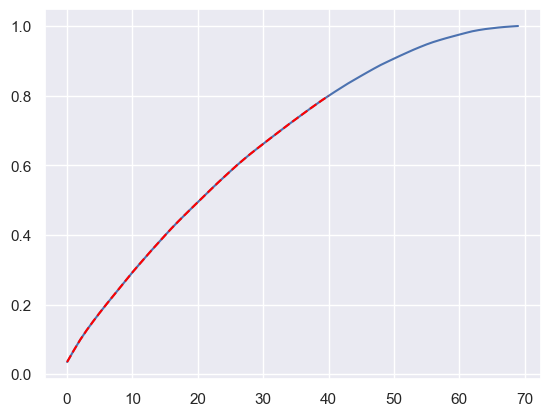

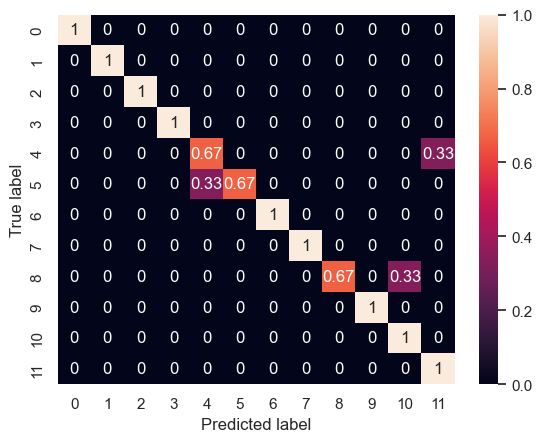

Accuracy: 91.67%, F1-score: 0.92
          - n_estimators      : 70
          - max_depth         : None
          - min_samples_split : 3
          - min_samples_leaf  : 1
          - max_features  : sqrt
          - bootstrap  : True
        


In [8]:
# FEATURE SELECTION 1: 

    ## Strengths: interpretable, relevant for this task
    ## Limitations: model-specific, may not generalize well, doesn't take into account the combined effects of parameters

# The parameter grid is adapted to shorten the GridSearchCV
param_grid = {
    'n_estimators': np.arange(60, 121, 10)[1:],
    'max_depth': [None] + list(np.arange(0, 12, 1)[1:]),
    'min_samples_split': np.arange(2, 7, 1),
    'min_samples_leaf': np.arange(1, 3, 1),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Based on the model with optimized parameters, we can select the features with the biggest contribution to the classification
ind = np.argsort(best_model.feature_importances_)[::-1]
ind_41 = ind[:41]

plt.plot(np.cumsum(best_model.feature_importances_[ind]))
plt.plot(np.cumsum(best_model.feature_importances_[ind_41]), '--', color = 'red')

# 41 features account for 80% of the prediction. We will only use these now
X_train_41, X_test_41 = X_train[:, ind_41], X_test[:, ind_41]

# Perform Hyperparameter tuning
(best_model_41, best_params_41, best_score_41, accuracy_41, F1_41, results_41) = grid_search_RF(X_train_41, X_test_41, y_train, y_test, param_grid, cv=6)

/Users/charl/Documents/EPFL/NX-421 NSSP/NSSP_env/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


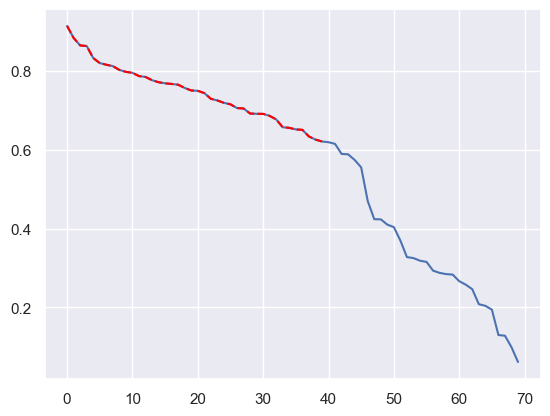

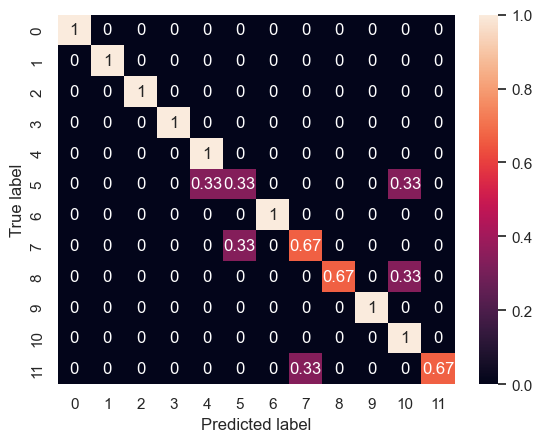

Accuracy: 86.11%, F1-score: 0.86
          - n_estimators      : 110
          - max_depth         : 6
          - min_samples_split : 6
          - min_samples_leaf  : 1
          - max_features  : log2
          - bootstrap  : True
        


In [9]:
# FEATURE SELECTION 2: MI

    ## Strengths: works well for non-linear relationships, model-agnostic (it does not depend on the specific classifier)
    ## Limitations: choose number of selected features, may overestimate importance of redundant features

# Import necessary functions for feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Calculate mutual information between each feature and the target variable.
# Mutual information is a measure of the dependency between variables.
# A higher value indicates a stronger relationship.
mutual_info = mutual_info_classif(X_train_z, y_train)

ind_MI = np.argsort(mutual_info)[::-1]

# Select the top 41 features based on mutual information scores.
# Note: You can change 'k' to 10 if you are working with fewer features.
k_best = SelectKBest(mutual_info_classif, k=41)
k_best.fit(X_train_z, y_train)

plt.plot(mutual_info[ind_MI])
plt.plot(mutual_info[ind_MI[:40]], '--', color = 'red')
# Transform the training and test datasets to only include the selected features.
X_train_MI = k_best.transform(X_train_z)
X_test_MI = k_best.transform(X_test_z)

(best_model_MI, best_params_MI, best_score_MI, accuracy_MI, F1_MI, results_MI) = grid_search_RF(X_train_MI, X_test_MI, y_train, y_test, param_grid, cv=6)


      Best score is the mean accuracy score averaged over all cross-validation folds
      


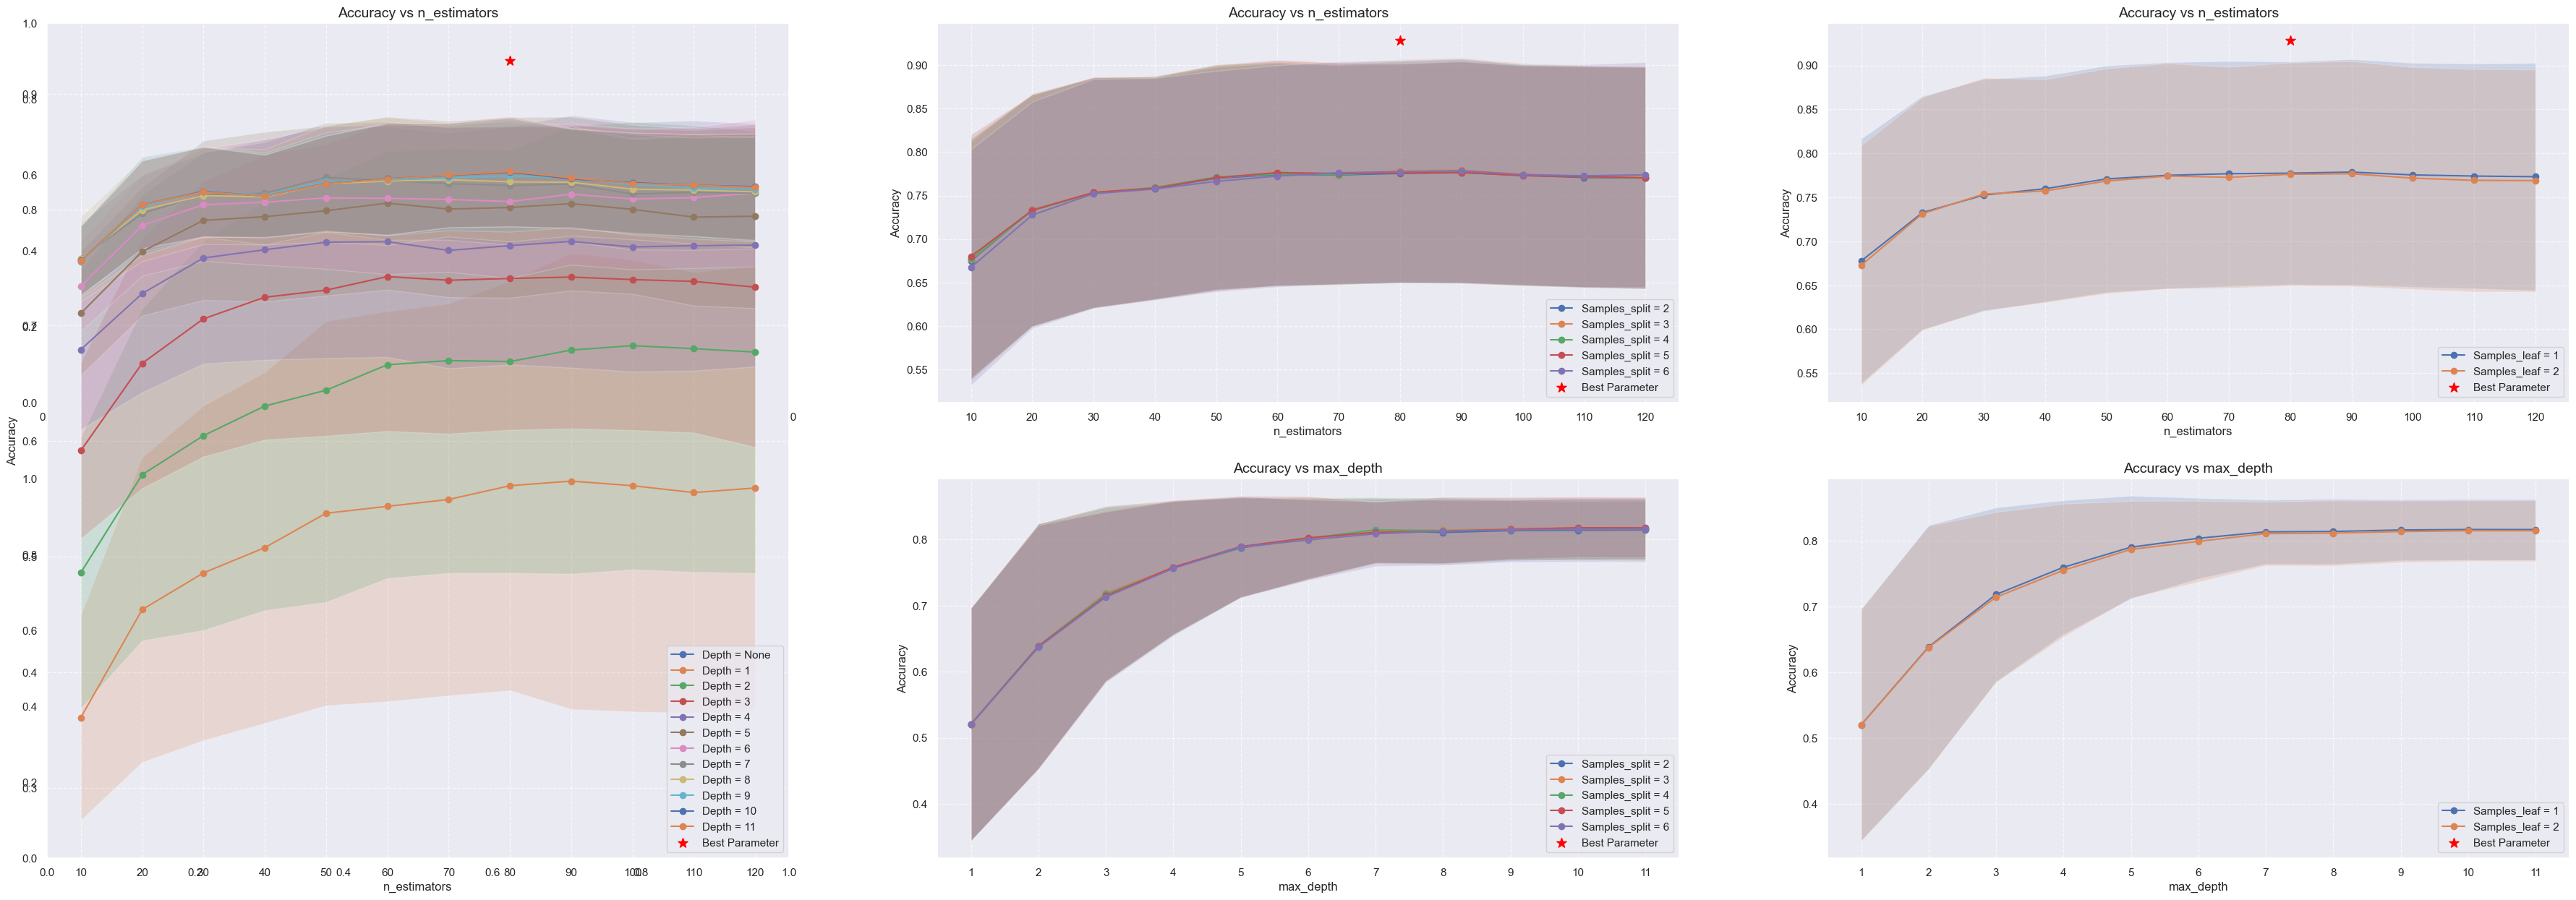


      Without feature importance selection
      The best parameters result in an accuracy on unseen data of 0.97, and F1 score of 0.97:
        - n_estimators      : 80
        - max_depth         : None
        - min_samples_split : 6
        - min_samples_leaf  : 1
      


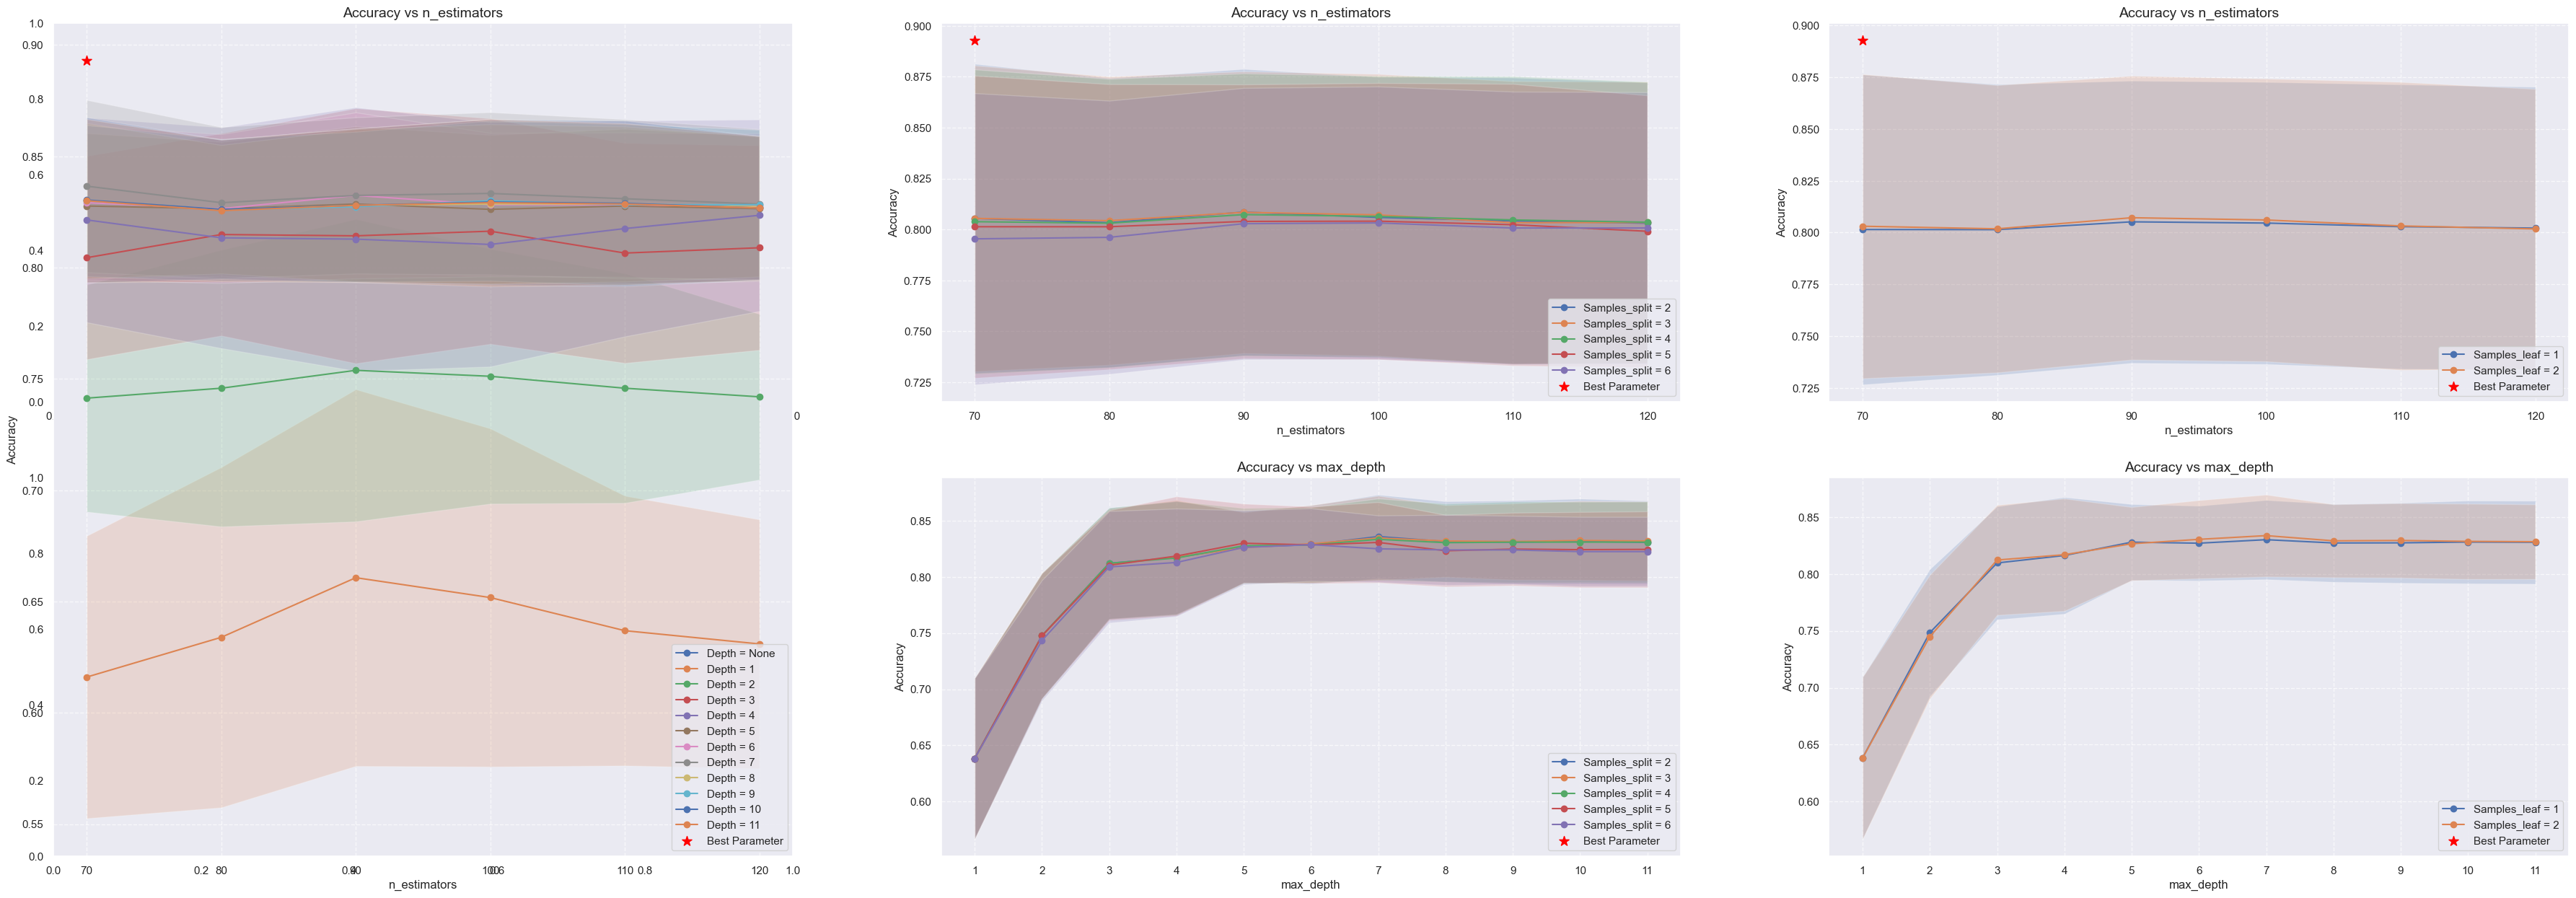


      With 80% feature contribution selection
      The best parameters result in an accuracy on unseen data of 0.92, and F1 score of 0.92:
        - n_estimators      : 70
        - max_depth         : None
        - min_samples_split : 3
        - min_samples_leaf  : 1
      


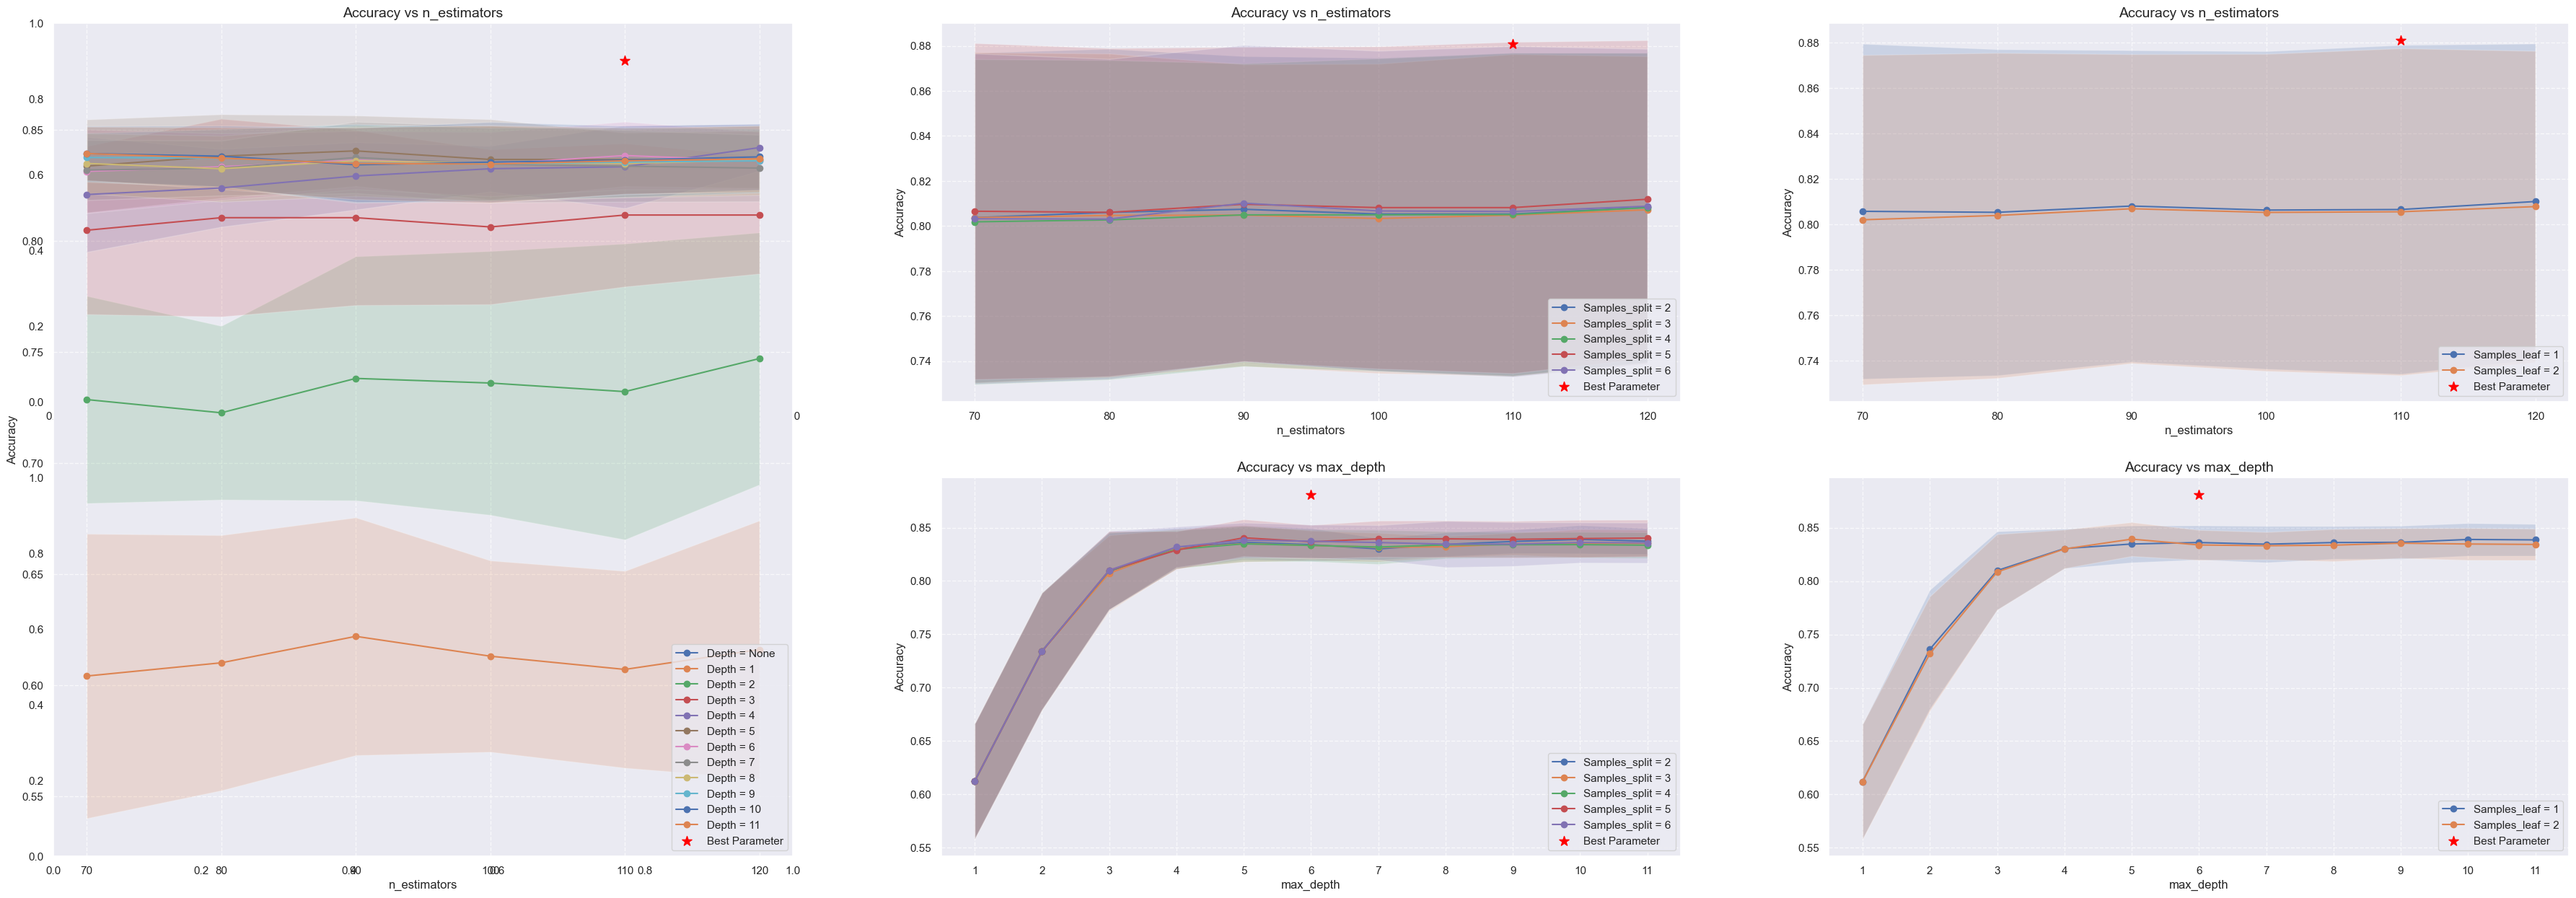


      With mutual information feature selection
      The best parameters result in an accuracy on unseen data of 0.86, and F1 score of 0.86:
        - n_estimators      : 110
        - max_depth         : 6
        - min_samples_split : 6
        - min_samples_leaf  : 1
      


In [12]:
print('''
      Best score is the mean accuracy score averaged over all cross-validation folds
      ''')

plot_paramgrid(results, best_score, best_params, param_grid)

print(f'''
      \033[1mWithout feature importance selection\033[0m
      The best parameters result in an accuracy on unseen data of {accuracy:.2f}, and F1 score of {F1_score:.2f}:
        - n_estimators      : {best_params['n_estimators']}
        - max_depth         : {best_params['max_depth']}
        - min_samples_split : {best_params['min_samples_split']}
        - min_samples_leaf  : {best_params['min_samples_leaf']}
      ''')

plot_paramgrid(results_41, best_score_41, best_params_41, param_grid)

print(f'''
      \033[1mWith 80% feature contribution selection\033[0m
      The best parameters result in an accuracy on unseen data of {accuracy_41:.2f}, and F1 score of {F1_41:.2f}:
        - n_estimators      : {best_params_41['n_estimators']}
        - max_depth         : {best_params_41['max_depth']}
        - min_samples_split : {best_params_41['min_samples_split']}
        - min_samples_leaf  : {best_params_41['min_samples_leaf']}
      ''')

plot_paramgrid(results_MI, best_score_MI, best_params_MI, param_grid)

print(f'''
      \033[1mWith mutual information feature selection\033[0m
      The best parameters result in an accuracy on unseen data of {accuracy_MI:.2f}, and F1 score of {F1_MI:.2f}:
        - n_estimators      : {best_params_MI['n_estimators']}
        - max_depth         : {best_params_MI['max_depth']}
        - min_samples_split : {best_params_MI['min_samples_split']}
        - min_samples_leaf  : {best_params_MI['min_samples_leaf']}
      ''')

# plot_paramgrid(results_svd, best_score_svd, best_params_svd, param_grid)

# print(f'''
#       \033[1mWith single value decomposition feature selection\033[0m
#       The best parameters result in an accuracy on unseen data of {accuracy_svd:.2f}, and F1 score of {F1_svd:.2f}:
#         - n_estimators      : {best_params_svd['n_estimators']}
#         - max_depth         : {best_params_svd['max_depth']}
#         - min_samples_split : {best_params_svd['min_samples_split']}
#         - min_samples_leaf  : {best_params_svd['min_samples_leaf']}
#       ''')